In [2]:
# All python dependencies
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
%matplotlib inline
import xarray as xr
import numpy as np
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import cmocean
import intake
import cftime
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.util import add_cyclic_point

/home/ncs001/.conda/envs/gem-vis/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [3]:
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=4, # The number of cores you want
    memory='128 GB', # Amount of memory
    processes=40, # How many processes
    queue='development', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=40:mem=128GB', # Specify resources
    walltime='06:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(1)

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [4]:
client

<Client: 'tcp://10.102.15.229:31657' processes=0 threads=0, memory=0 B>

In [5]:
def wrapper(ds):
    ds = ds.copy()
    #ds = rename_cmip6(ds)
    #ds = replace_x_y_nominal_lat_lon(ds)
    
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
    if ('bnds' in ds.dims): 
        ds=ds.drop_dims('bnds')
    if ('vertex' in ds.dims): 
        ds=ds.drop_dims('vertex')
    if ('height' in ds.dims): 
        ds=ds.drop_dims('height')
    if ('height' in ds): 
        ds=ds.drop_vars('height')
    return ds

In [6]:
member_id_p1 = [f'r{x}i1p1f1' for x in range(1,26)]
member_id_p2 = [f'r{x}i1p2f1' for x in range(1,26)]
member_id = member_id_p1 + member_id_p2

In [7]:
# Load CanESM5 data
# This is the location of the intake database
start = '1850-01-01'
end   = '2014-12-31'
cat_url_cmip6 = "/home/scrd106/model_output/intake-catalogues/cccma_cmip6.json"

col = intake.open_esm_datastore(cat_url_cmip6)

query = dict(variable_id=['siconc', 'tos'], table_id=['SImon', 'Omon'], source_id='CanESM5', 
             experiment_id=['historical'], member_id=member_id)
cat = col.search(**query)

# chunking of time=50 works for 1980 months and 40 processors
dset_dict = cat.to_dataset_dict(preprocess=wrapper, xarray_open_kwargs={'chunks':{'time':50}})

for k in dset_dict.keys():
    if 'SImon' in k:
        historical_sic_ds = dset_dict[k].sel(time=slice(start, end)).squeeze()
    elif 'Omon' in k:
        historical_tos_ds = dset_dict[k].sel(time=slice(start, end)).squeeze()   


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [8]:
# Load CanESM5 hist-nat data
# This is the location of the intake database
start = '1850-01-01'
end   = '2014-12-31'

cat_url_cmip6 = "/home/scrd106/model_output/intake-catalogues/cccma_cmip6.json"

col = intake.open_esm_datastore(cat_url_cmip6)

query = dict(variable_id=['siconc', 'tos'], table_id=['SImon', 'Omon'], source_id='CanESM5', 
             experiment_id=['hist-nat'])
cat = col.search(**query)

dset_dict = cat.to_dataset_dict(preprocess=wrapper, xarray_open_kwargs={'chunks':{'time':50}})

for k in dset_dict.keys():
    if 'SImon' in k:
        histnat_sic_ds = dset_dict[k].sel(time=slice(start, end)).squeeze()
    elif 'Omon' in k:
        histnat_tos_ds = dset_dict[k].sel(time=slice(start, end)).squeeze()  


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [9]:
compnat_tos_ds = xr.open_dataset('/home/ncs001/site5/eps_anal/compnat_tos.nc',chunks={'time':50, 'member_id':1})
compnat_sic_ds = xr.open_dataset('/home/ncs001/site5/eps_anal/compnat_sic.nc',chunks={'time':50, 'member_id':1})

In [10]:
%%time
# The historical 
hist_sic_ensmean = xr.load_dataset('/home/ncs001/site5/eps_anal/hist_sic_ensmean.nc')
hist_tos_ensmean = xr.load_dataset('/home/ncs001/site5/eps_anal/hist_tos_ensmean.nc')
hist_sic_ensstd = xr.load_dataset('/home/ncs001/site5/eps_anal/hist_sic_ensstd.nc')
hist_tos_ensstd = xr.load_dataset('/home/ncs001/site5/eps_anal/hist_tos_ensstd.nc')

# The hist-nat 
histnat_sic_ensmean = xr.load_dataset('/home/ncs001/site5/eps_anal/histnat_sic_ensmean.nc')
histnat_tos_ensmean = xr.load_dataset('/home/ncs001/site5/eps_anal/histnat_tos_ensmean.nc')
histnat_sic_ensstd = xr.load_dataset('/home/ncs001/site5/eps_anal/histnat_sic_ensstd.nc') 
histnat_tos_ensstd = xr.load_dataset('/home/ncs001/site5/eps_anal/histnat_tos_ensstd.nc')

# The comp-nat (our computed version of hist-nat) 
compnat_sic_ensmean = xr.load_dataset('/home/ncs001/site5/eps_anal/compnat_sic_ensmean.nc')
compnat_tos_ensmean = xr.load_dataset('/home/ncs001/site5/eps_anal/compnat_tos_ensmean.nc')
compnat_sic_ensstd = xr.load_dataset('/home/ncs001/site5/eps_anal/compnat_sic_ensstd.nc') 
compnat_tos_ensstd = xr.load_dataset('/home/ncs001/site5/eps_anal/compnat_tos_ensstd.nc')

CPU times: user 543 ms, sys: 3.02 s, total: 3.56 s
Wall time: 21.8 s


In [11]:
cat_url_cmip6 = "/home/scrd106/model_output/intake-catalogues/cccma_cmip6.json"

col = intake.open_esm_datastore(cat_url_cmip6)

query = dict(variable_id=['areacello'], table_id=['Ofx'], source_id='CanESM5', 
             experiment_id=['historical'], member_id='r1i1p1f1')
cat = col.search(**query)

dset_dict = cat.to_dataset_dict()
areacello = dset_dict['CMIP.CCCma.CanESM5.historical.Ofx.gn'].areacello
areacello


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<xarray.DataArray 'areacello' (member_id: 1, dcpp_init_year: 1, j: 291, i: 360)>
dask.array<broadcast_to, shape=(1, 1, 291, 360), dtype=float32, chunksize=(1, 1, 291, 360), chunktype=numpy.ndarray>
Coordinates:
  * j               (j) int32 0 1 2 3 4 5 6 7 ... 284 285 286 287 288 289 290
  * i               (i) int32 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
    latitude        (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude       (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Attributes:
    standard_name:  cell_area
    long_name:      Grid-Cell Area for Ocean Variables
    comment:        Horizontal area of ocean grid cells
    units:          m2
    original_name:  areacello
    cell_methods:   area: sum

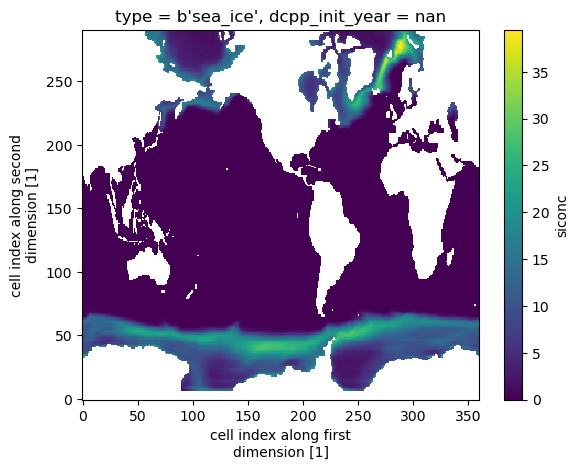

In [12]:
histnat_sic_ensstd.sel(time=slice('1980','2010')).mean(dim='time').siconc.plot()

Text(0.5, 1.0, 'Difference in sea-ice variance')

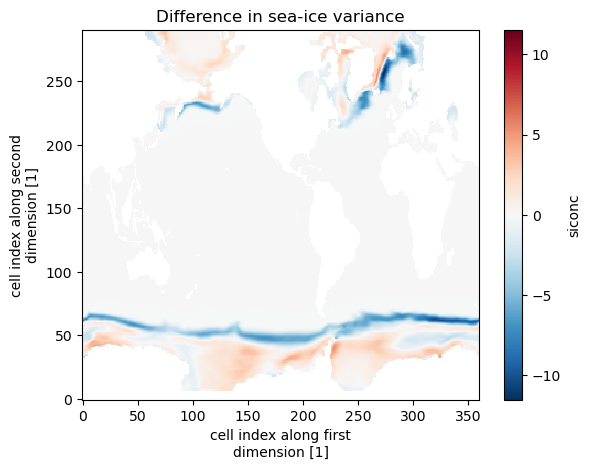

: 

In [39]:
(compnat_sic_ensstd.sel(time=slice('1980','2010')).mean(dim='time').siconc - 
 histnat_sic_ensstd.sel(time=slice('1980','2010')).mean(dim='time').siconc).plot()
plt.title('Difference in sea-ice variance')

## Sea-ice concentration

### Comparison between "histnat" and "compnat" variance

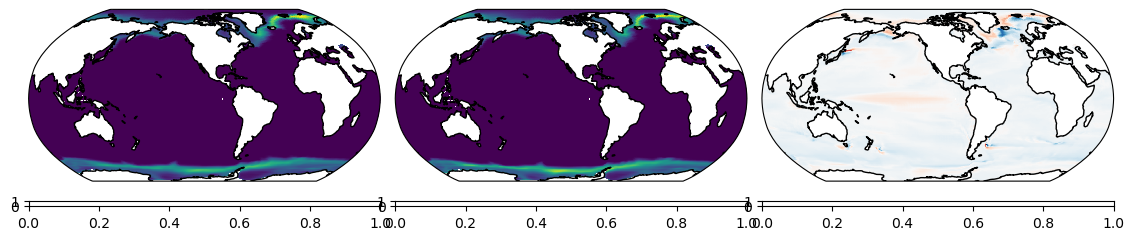

In [14]:
fig = plt.figure(figsize=(14,10))
cmap2=plt.cm.RdBu_r

start_year='1990'
end_year='2014'

projection=ccrs.Robinson(central_longitude=250)
axes_class = (GeoAxes,
                  dict(projection=projection))

grid = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(1, 3),
                    axes_pad=0.15,
                    cbar_location='bottom',
                    cbar_mode='each',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    label_mode='')  # note the empty label_modead=0.05
                
ax1 = grid[0]
ax2 = grid[1]
ax3 = grid[2]

ax1.pcolormesh(histnat_sic_ensstd.longitude,histnat_sic_ensstd.latitude, 
               histnat_sic_ensstd.sel(time=slice(start_year,end_year)).mean(dim='time').siconc, 
               transform=ccrs.PlateCarree())

ax2.pcolormesh(compnat_sic_ensstd.longitude,compnat_sic_ensstd.latitude, 
               compnat_sic_ensstd.sel(time=slice(start_year,end_year)).mean(dim='time').siconc, 
               transform=ccrs.PlateCarree())
diff = (compnat_tos_ensstd.sel(time=slice(start_year,end_year)).mean(dim='time').tos -
        histnat_tos_ensstd.sel(time=slice(start_year,end_year)).mean(dim='time').tos).compute(scheduler=client)

ax3.pcolormesh(compnat_sic_ensstd.longitude,compnat_sic_ensstd.latitude, 
               diff, 
               transform=ccrs.PlateCarree(), cmap='RdBu_r')

for ax in grid:
    ax.coastlines()

Text(0.5, 1.0, 'Difference in SST variance')

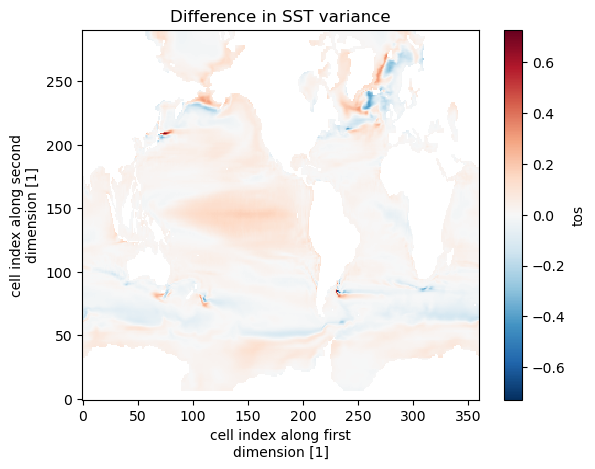

In [37]:
(compnat_tos_ensstd.sel(time=slice('1980','2010')).mean(dim='time').tos -
 histnat_tos_ensstd.sel(time=slice('1980','2010')).mean(dim='time').tos).plot()
plt.title('Difference in SST variance')

In [16]:
ga = areacello.sum(dim=['i','j']).values
histnat_tos_ensmean_gm = (histnat_tos_ensmean*areacello).sum(dim=['i','j'])/ga
hist_tos_ensmean_gm = (hist_tos_ensmean*areacello).sum(dim=['i','j'])/ga
compnat_tos_ensmean_gm = (compnat_tos_ensmean*areacello).sum(dim=['i','j'])/ga

In [17]:
compnat_tos_gm = ((compnat_tos_ds*areacello.values).sum(dim=['i','j'])/ga).persist(scheduler=client)
histnat_tos_gm = ((histnat_tos_ds*areacello.values).sum(dim=['i','j'])/ga).persist(scheduler=client)
historical_tos_gm = ((historical_tos_ds*areacello.values).sum(dim=['i','j'])/ga).persist(scheduler=client)

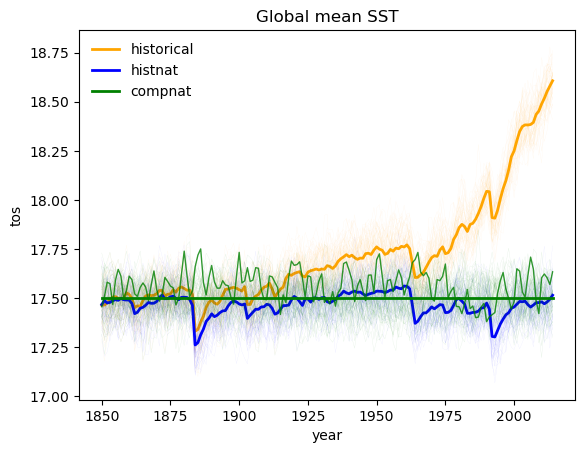

In [18]:
# historical
plt.plot(historical_tos_gm.isel(member_id=0).groupby('time.year').mean(dim='time').compute(scheduler=client).year.values.squeeze(),
         historical_tos_gm.groupby('time.year').mean(dim='time').compute(scheduler=client).tos.values, color='orange', linewidth=0.15, alpha=0.1)
hist_tos_ensmean_gm.groupby('time.year').mean().tos.plot(color='orange', linewidth=2, label='historical')

# hisnat
plt.plot(histnat_tos_gm.isel(member_id=0).groupby('time.year').mean(dim='time').compute(scheduler=client).year.values.squeeze(),
         histnat_tos_gm.groupby('time.year').mean(dim='time').compute(scheduler=client).tos.values, color='blue', linewidth=0.15, alpha=0.1)
histnat_tos_ensmean_gm.groupby('time.year').mean().tos.plot(color='blue', linewidth=2, label='histnat')

# compnat
plt.plot(compnat_tos_gm.isel(member_id=0).groupby('time.year').mean(dim='time').compute(scheduler=client).year.values.squeeze(),
         compnat_tos_gm.groupby('time.year').mean(dim='time').compute(scheduler=client).tos.values, color='g', linewidth=0.25, alpha=0.1)
compnat_tos_ensmean_gm.groupby('time.year').mean().tos.plot(color='g', linewidth=2, label='compnat')
plt.plot(compnat_tos_gm.isel(member_id=0).groupby('time.year').mean(dim='time').compute(scheduler=client).year.values.squeeze(),
         compnat_tos_gm.isel(member_id=0).groupby('time.year').mean(dim='time').compute(scheduler=client).tos.values, color='g', linewidth=1, alpha=0.8)
plt.title('Global mean SST')
plt.legend(loc=2, frameon=False)

In [19]:
histnat_tos_ensstd_gm = (histnat_tos_ensstd*areacello).sum(dim=['i','j'])/ga
hist_tos_ensstd_gm = (hist_tos_ensstd*areacello).sum(dim=['i','j'])/ga
compnat_tos_ensstd_gm = (compnat_tos_ensstd*areacello).sum(dim=['i','j'])/ga

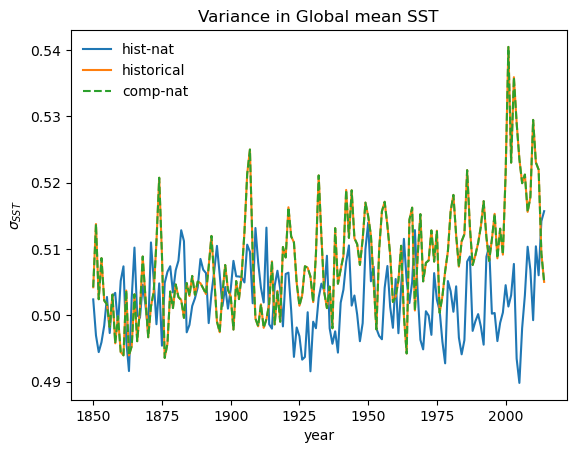

In [36]:
histnat_tos_ensstd_gm.tos.groupby('time.year').mean().plot(label='hist-nat')
hist_tos_ensstd_gm.tos.groupby('time.year').mean().plot(label='historical')
compnat_tos_ensstd_gm.tos.groupby('time.year').mean().plot(linestyle='--', label='comp-nat')
plt.title('Variance in Global mean SST')
plt.ylabel('$\sigma _{SST}$')
plt.legend(loc=2, frameon=False)

In [21]:
histnat_sic_ensmean_gs = (histnat_sic_ensmean*areacello).sum(dim=['i','j'])
hist_sic_ensmean_gs = (hist_sic_ensmean*areacello).sum(dim=['i','j'])
compnat_sic_ensmean_gs = (compnat_sic_ensmean*areacello).sum(dim=['i','j'])

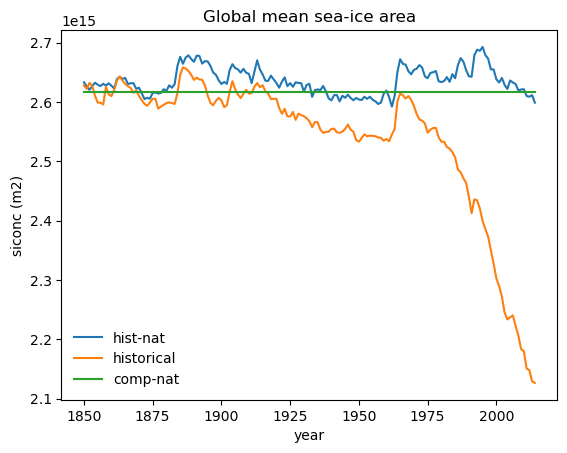

In [34]:
histnat_sic_ensmean_gs.groupby('time.year').mean().siconc.plot(label='hist-nat')
hist_sic_ensmean_gs.groupby('time.year').mean().siconc.plot(label='historical')
compnat_sic_ensmean_gs.groupby('time.year').mean().siconc.plot(label='comp-nat')
plt.title('Global mean sea-ice area')
plt.ylabel('siconc (m2)')
plt.legend(loc='lower left', frameon=False)

In [23]:
histnat_sic_ensstd_gm = (histnat_sic_ensstd*areacello).sum(dim=['i','j'])/ga
hist_sic_ensstd_gm = (hist_sic_ensstd*areacello).sum(dim=['i','j'])/ga
compnat_sic_ensstd_gm = (compnat_sic_ensstd*areacello).sum(dim=['i','j'])/ga

In [35]:
histnat_sic_ensstd_gm.siconc.groupby('time.year').mean().plot(label='hist-nat')
hist_sic_ensstd_gm.siconc.groupby('time.year').mean().plot(label='historical')
compnat_sic_ensstd_gm.siconc.groupby('time.year').mean().plot(linestyle='--', label='comp-nat')
plt.title('Variance in global sea-ice area')
plt.xlabel('$\sigma$ siconc')
plt.legend(loc='lower left', frameon=False)